In [1]:
import pandas as pd # table operations
import numpy as np # linear algebra
import seaborn as sns # visualizing
import os # getting path
from sklearn.utils import shuffle
import matplotlib.pyplot as plt # visualizing
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img # prepare image
import cv2 # haar cascade
from scipy.spatial import distance
import glob
from warnings import filterwarnings
from tensorflow.keras.applications import VGG19 # classify modle
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint # save best model weights
from tensorflow.keras.models import Model, load_model # load model
from sklearn.metrics import confusion_matrix
from skimage import io
filterwarnings("ignore")

KeyboardInterrupt: 

In [ ]:
path  = "/content/Face Mask Dataset/"

In [ ]:
dataset = {"image_path":[],"mask_status":[],"where":[]}
for where in os.listdir(path):
    for status in os.listdir(path+"/"+where):
        for image in glob.glob(path+where+"/"+status+"/"+"*.png"):
            dataset["image_path"].append(image)
            dataset["mask_status"].append(status)
            dataset["where"].append(where)
dataset = pd.DataFrame(dataset)
dataset

image_path  mask_status  where
0      /content/Face Mask Dataset/Train/WithMask/Augm...     WithMask  Train
1      /content/Face Mask Dataset/Train/WithMask/Augm...     WithMask  Train
2      /content/Face Mask Dataset/Train/WithMask/Augm...     WithMask  Train
3      /content/Face Mask Dataset/Train/WithMask/Augm...     WithMask  Train
4      /content/Face Mask Dataset/Train/WithMask/Augm...     WithMask  Train
...                                                  ...          ...    ...
11787  /content/Face Mask Dataset/Test/WithoutMask/15...  WithoutMask   Test
11788  /content/Face Mask Dataset/Test/WithoutMask/45...  WithoutMask   Test
11789  /content/Face Mask Dataset/Test/WithoutMask/22...  WithoutMask   Test
11790  /content/Face Mask Dataset/Test/WithoutMask/31...  WithoutMask   Test
11791  /content/Face Mask Dataset/Test/WithoutMask/19...  WithoutMask   Test

[11792 rows x 3 columns]

Step 4: Data preprocessing for building the mask detection Keras model
We will now pass our datasets into Keras ImageDataGenerator() to perform some preliminary data augmentation steps such as rescaling.

In [ ]:
dataset.value_counts("mask_status")

mask_status
WithoutMask    5909
WithMask       5883
dtype: int64

With Mask: 5883,
Without Mask: 5909



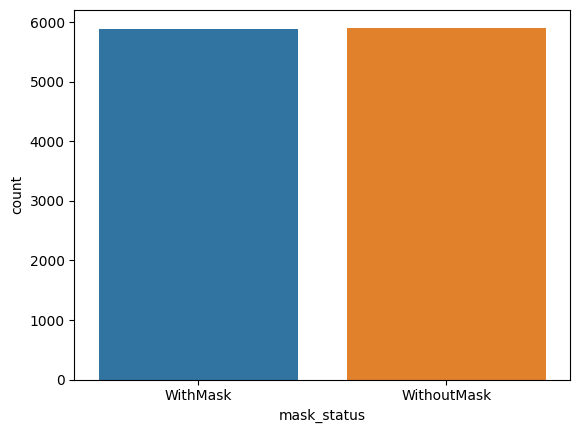

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

mask = dataset["mask_status"].value_counts()[1]
withoutmask = dataset["mask_status"].value_counts()[0]

print(f"With Mask: {mask},\nWithout Mask: {withoutmask}\n")

sns.countplot(x="mask_status", data=dataset)
plt.show()


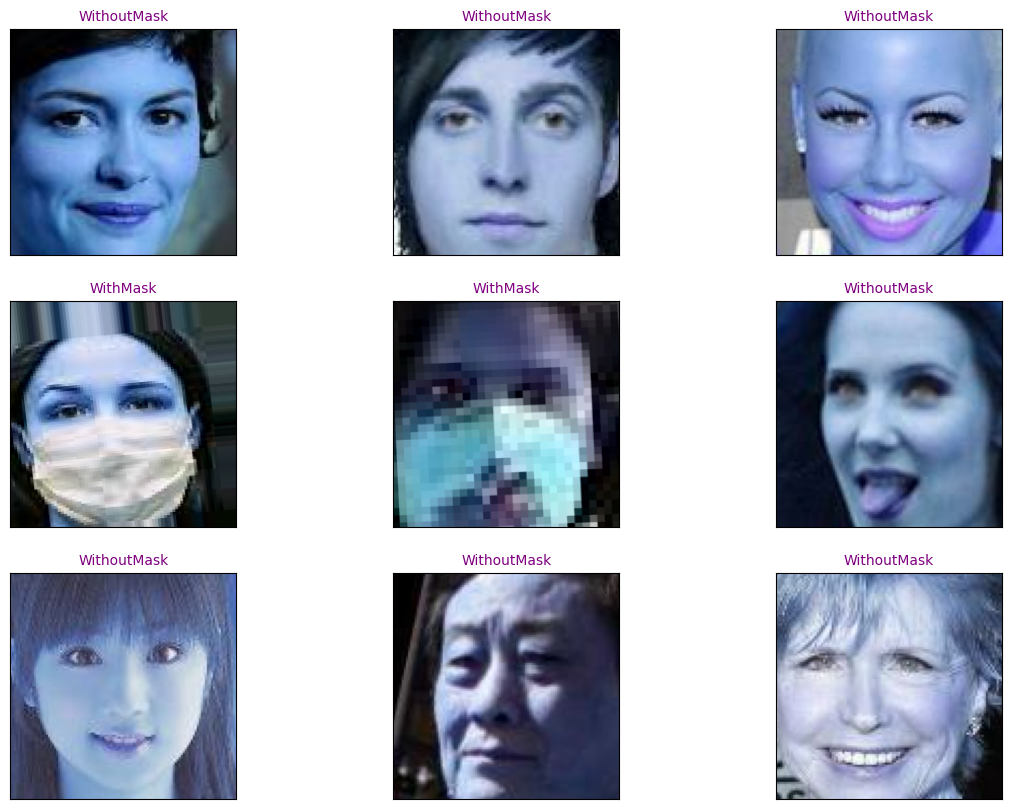

In [ ]:
plt.figure(figsize = (14,10))
for i in range(9):
    random = np.random.randint(1,len(dataset))
    plt.subplot(3,3,i+1)
    plt.imshow(cv2.imread(dataset.loc[random,"image_path"]))
    plt.title(dataset.loc[random, "mask_status"], size = 10, color = "purple")
    plt.xticks([])
    plt.yticks([])

plt.show()

In [ ]:
train_df = dataset[dataset["where"] == "Train"]
test_df = dataset[dataset["where"] == "Test"]
valid_df = dataset[dataset["where"] == "Validation"]

In [ ]:
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)
valid_df = valid_df.sample(frac=1)

In [ ]:
train_df.head()

image_path  mask_status  where
2784  /content/Face Mask Dataset/Train/WithMask/Augm...     WithMask  Train
1946  /content/Face Mask Dataset/Train/WithMask/Augm...     WithMask  Train
2905  /content/Face Mask Dataset/Train/WithMask/1301...     WithMask  Train
6915  /content/Face Mask Dataset/Train/WithoutMask/2...  WithoutMask  Train
5726  /content/Face Mask Dataset/Train/WithoutMask/4...  WithoutMask  Train

In [ ]:
valid_df.head()

image_path  mask_status  \
10362  /content/Face Mask Dataset/Validation/WithMask...     WithMask   
10453  /content/Face Mask Dataset/Validation/WithoutM...  WithoutMask   
10173  /content/Face Mask Dataset/Validation/WithMask...     WithMask   
10373  /content/Face Mask Dataset/Validation/WithMask...     WithMask   
10403  /content/Face Mask Dataset/Validation/WithoutM...  WithoutMask   

            where  
10362  Validation  
10453  Validation  
10173  Validation  
10373  Validation  
10403  Validation

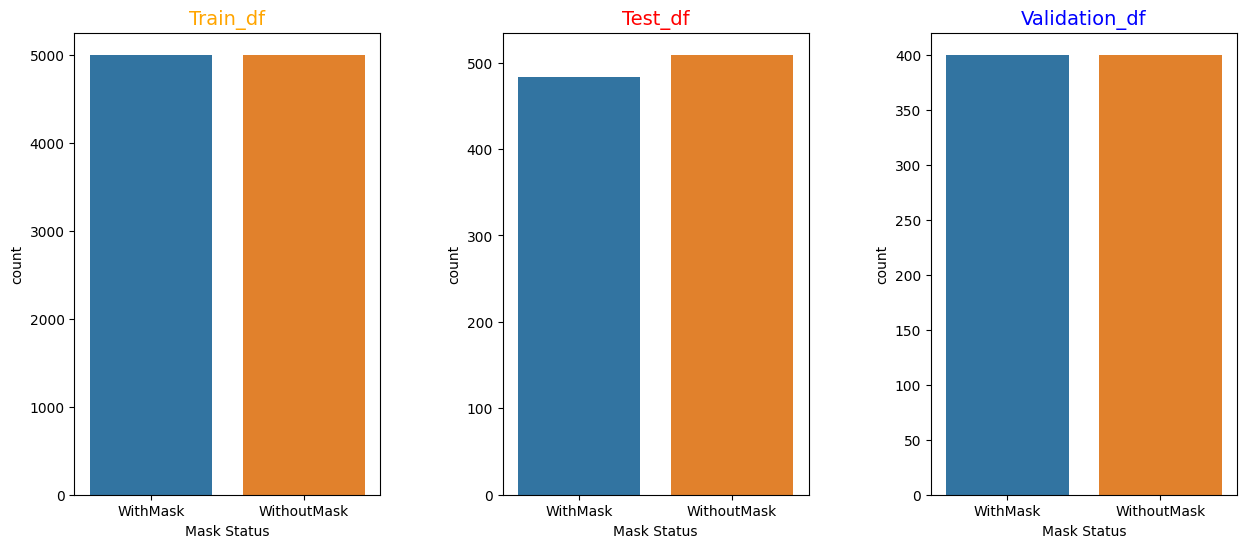

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have train_df, test_df, and valid_df dataframes
# If not, load your dataframes here

plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
train_df["mask_status"] = train_df["mask_status"].astype("category")
sns.countplot(x="mask_status", data=train_df)
plt.title("Train_df", size=14, color="orange")
plt.xlabel("Mask Status")

plt.subplot(1, 3, 2)
test_df["mask_status"] = test_df["mask_status"].astype("category")
sns.countplot(x="mask_status", data=test_df)
plt.title("Test_df", size=14, color="red")
plt.xlabel("Mask Status")

plt.subplot(1, 3, 3)
valid_df["mask_status"] = valid_df["mask_status"].astype("category")
sns.countplot(x="mask_status", data=valid_df)
plt.title("Validation_df", size=14, color="blue")
plt.xlabel("Mask Status")

plt.subplots_adjust(wspace=0.4)  # Adjust the horizontal space between subplots

plt.show()



In [ ]:
datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator=datagen.flow_from_dataframe(
dataframe=train_df,
directory="../input",
x_col="image_path",
y_col="mask_status",
batch_size=80,
seed=42,
shuffle=False,
class_mode="binary",
target_size=(150,150))

Found 10000 validated image filenames belonging to 2 classes.


In [ ]:
valid_generator=datagen.flow_from_dataframe(
dataframe=valid_df,
directory="../input",
x_col="image_path",
y_col="mask_status",
batch_size=80,
seed=42,
shuffle=False,
class_mode="binary",
target_size=(150,150))

Found 800 validated image filenames belonging to 2 classes.


In [ ]:
test_generator=datagen.flow_from_dataframe(
dataframe=test_df,
directory="../input",
x_col="image_path",
y_col="mask_status",
batch_size=80,
seed=42,
shuffle=False,
class_mode="binary",
target_size=(150,150))

Found 992 validated image filenames belonging to 2 classes.


In [ ]:
model = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
for layer in model.layers[2:]:
  layer.trainable = False
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
x=Flatten()(model.output)
x2 = Dense(128, activation="relu")(x)
output=Dense(1,activation='sigmoid')(x2) #
model=Model(model.input,output)

In [ ]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
checkpoint = ModelCheckpoint("classify_model.h5", save_best_only=True, verbose = 1)

In [ ]:
model.compile(optimizer="adam", loss = "binary_crossentropy", metrics = ["accuracy"])
history = model.fit_generator(train_generator,validation_data  = valid_generator, epochs = 10, steps_per_epoch=(len(train_generator.labels) / 80) ,validation_steps=(len(valid_generator.labels)/80), callbacks =[checkpoint])

Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 0.0864 - accuracy: 0.9671
Epoch 1: val_loss improved from inf to 0.01143, saving model to classify_model.h5
125/125 [==============================] - 71s 473ms/step - loss: 0.0864 - accuracy: 0.9671 - val_loss: 0.0114 - val_accuracy: 0.9975
Epoch 2/10
125/125 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9977
Epoch 2: val_loss improved from 0.01143 to 0.00842, saving model to classify_model.h5
125/125 [==============================] - 59s 471ms/step - loss: 0.0105 - accuracy: 0.9977 - val_loss: 0.0084 - val_accuracy: 0.9975
Epoch 3/10
125/125 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.9985
Epoch 3: val_loss improved from 0.00842 to 0.00512, saving model to classify_model.h5
125/125 [==============================] - 59s 467ms/step - loss: 0.0059 - accuracy: 0.9985 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 4/10
125/125 [==============================] - ET

In [ ]:
model = load_model("classify_model.h5")

In [ ]:
face_model=cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')

In [ ]:
img = io.imread('/content/_113298561_a6a17a72-013c-4d04-ae38-542e6f78ea44.jpg')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)


for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(img)

In [ ]:


def detectMask(path):
    img = io.imread(path)
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

    faces = face_model.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4)

    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 1)

    plt.figure(figsize=(12, 12))
    plt.imshow(img)

    if len(faces) >= 1:
        label = [0 for i in range(len(faces))]
        for i in range(len(faces) - 1):
            for j in range(i + 1, len(faces)):
                dist = distance.euclidean(faces[i][:2], faces[j][:2])
                if dist < MIN_DISTANCE:
                    label[i] = 1
                    label[j] = 1

        new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Colored output image
        for i in range(len(faces)):
            (x, y, w, h) = faces[i]
            crop = new_img[y:y + h, x:x + w]
            crop = cv2.resize(crop, (150, 150))
            crop = np.reshape(crop, [1, 150, 150, 3]) / 255.0
            mask_result = model.predict(crop)
            cv2.putText(new_img, mask_label[round(mask_result[0][0])], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, dist_label[label[i]], 2)
            cv2.rectangle(new_img, (x, y), (x + w, y + h), dist_label[label[i]], 1)

        plt.figure(figsize=(10, 10))
        plt.imshow(new_img)
    else:
        print("No Face!")

1/1 [==============================] - 0s 20ms/step


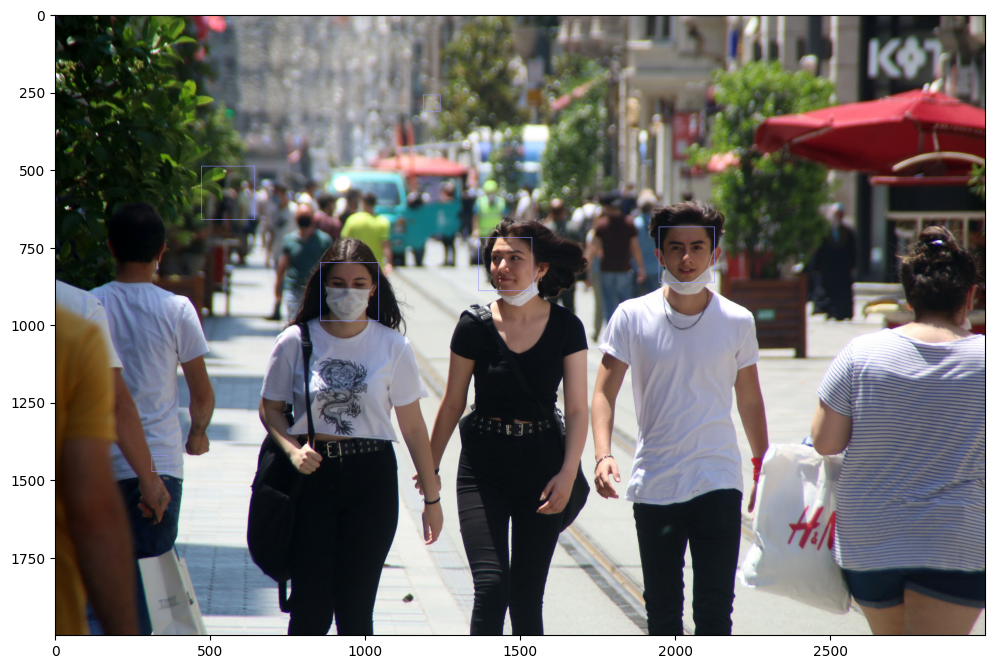

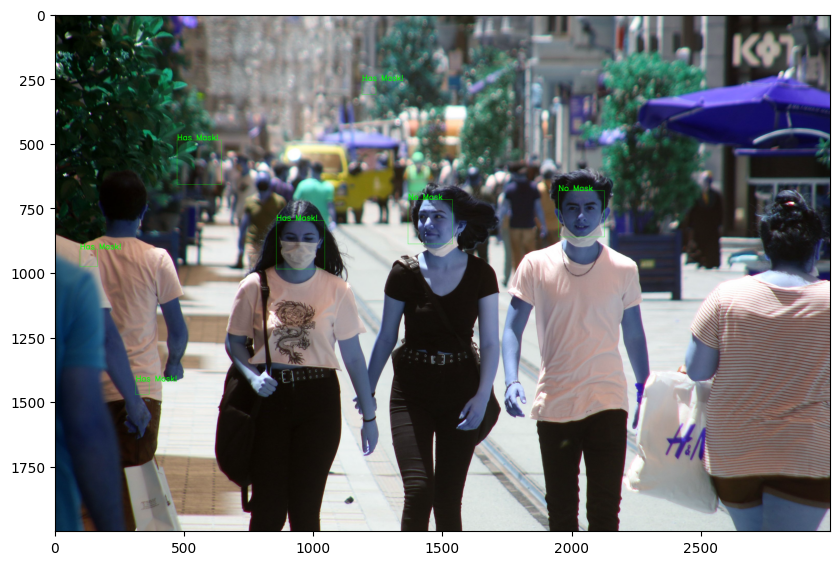

In [ ]:
imgPath="/content/42169.jpg"
detectMask(imgPath)


1/1 [==============================] - 0s 20ms/step


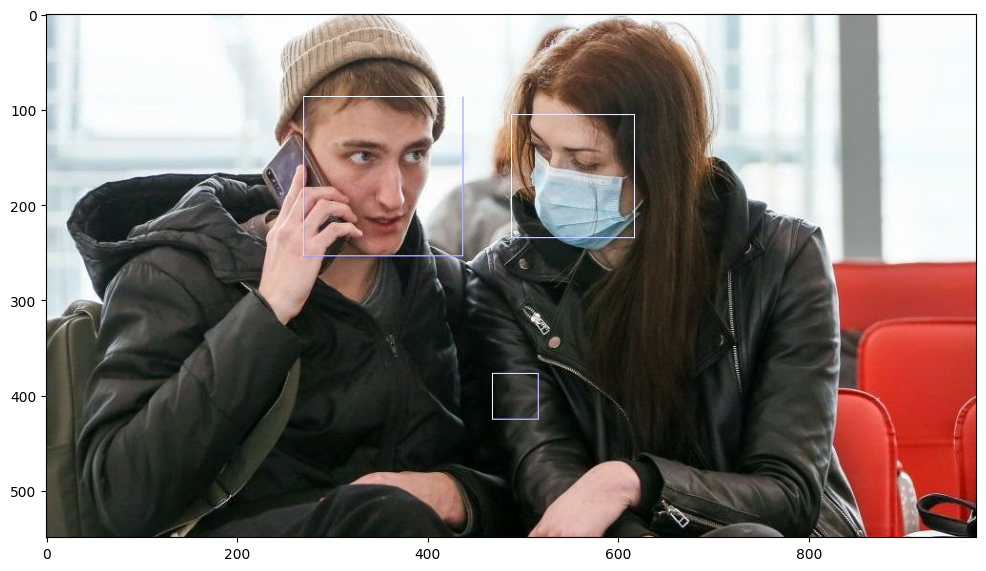

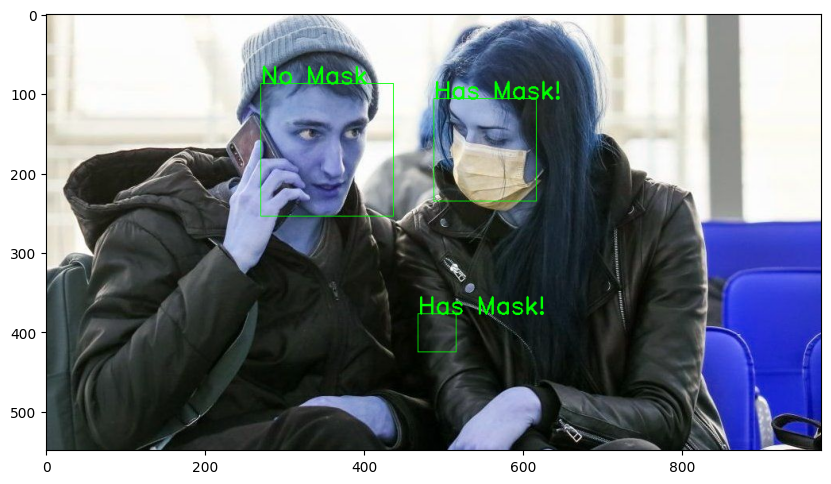

In [ ]:
imgPath="/content/_113298561_a6a17a72-013c-4d04-ae38-542e6f78ea44.jpg"
detectMask(image_path)

1/1 [==============================] - 0s 30ms/step


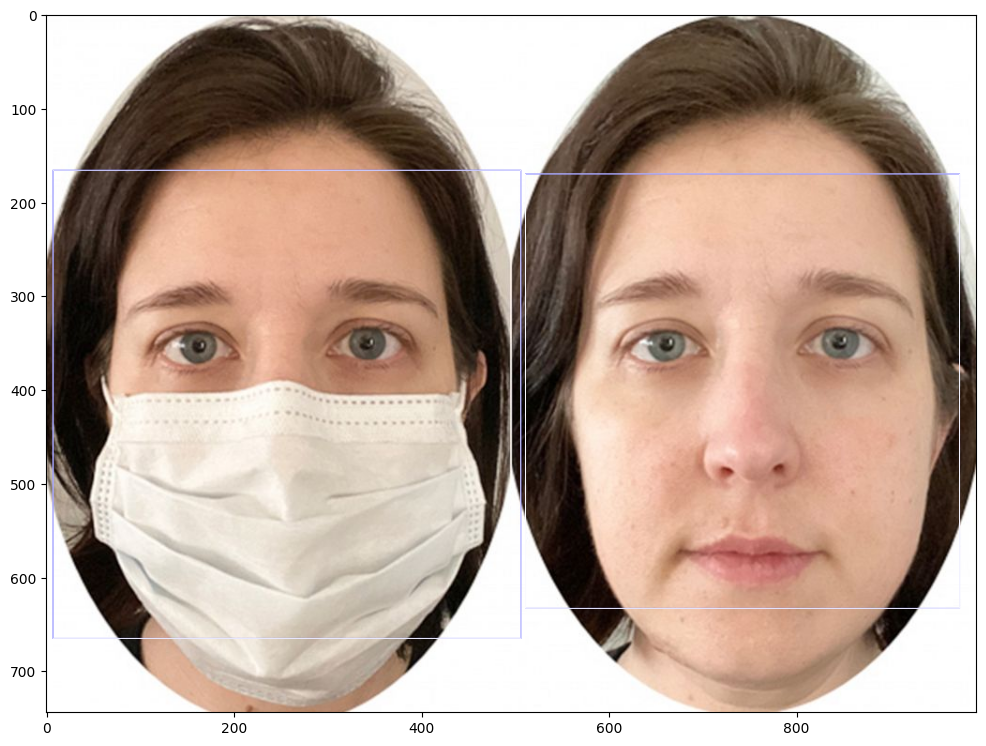

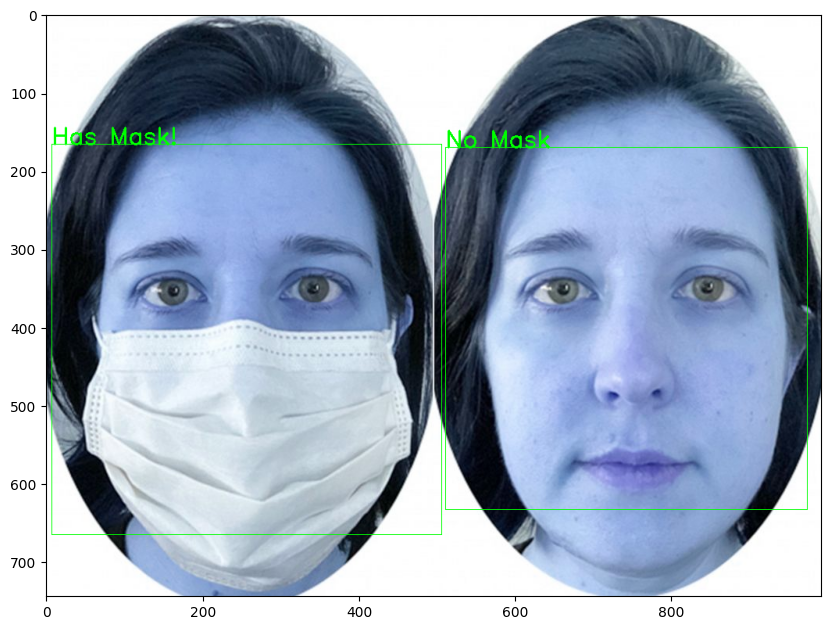

In [ ]:
imgPath="/content/woman-mask-split-04-ht-jt-210316_1615932165011_hpEmbed_4x3_992.jpg"
detectMask(imgPath)